In [0]:
import tensorflow as tf
import numpy as np
import tkinter

/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
import time

In [0]:

from PIL import ImageTk, Image

root = tkinter.Tk()
#Setting it up
keno = ImageTk.PhotoImage(Image.open("../keno.png"))
red = ImageTk.PhotoImage(Image.open("../kokkino.png"))
blue = ImageTk.PhotoImage(Image.open("../ble.png"))

In [0]:
def same(a):
    
    for i in range( len(a) ):
        if a[0] != a[i]:
            return ( False )
        
    return ( True )

#reverse state for 2nd agent, so that it can make predictions according to what the 1st agent has learned so far
def rev( a ):
    b = a.copy()
    b[ a == 1 ] = 2
    b[ a == 2 ] = 1
    return ( b.copy() )

In [0]:
class Environment:
    
    def __init__(self):
        self.R, self.C = 6,7
        self.board = np.zeros( (self.R,self.C), dtype='uint8' )
    
    def reset(self):
        for i in range( self.R ):
            for j in range( self.C ):
                self.board[i][j] = 0
    
    def step(self,who,action):
        
        placed = False
        for j in range( self.R-1, -1, -1 ):
            if self.board[j][action] == 0:
                self.board[j][action] = who
                placed = True
                break
        
        return ( placed )
    
    def getState(self):
        return self.board.copy()
    
    def isFinal(self):
        
        #check horizontal
        for i in range( self.R ):
            for j in range( self.C ):
                if self.board[i][j] != 0:
                    x, y = i, j
                    a = []
                    for k in range(4):
                        a.append( self.board[x][y] )
                        y += 1
                        if y >= self.C:
                            break
                    if same( np.array(a) ) and len(a) == 4:
                        return ( a[0] )
                
        #check vertical
        for i in range( self.R ):
            for j in range( self.C ):
                if self.board[i][j] != 0:
                    x, y = i, j
                    a = []
                    for k in range(4):
                        a.append( self.board[x][y] )
                        x += 1
                        if x >= self.R:
                            break
                    if same( np.array(a) ) and len(a) == 4:
                        return ( a[0] )
                    
        #check diagonal
        for i in range( self.R-3 ):
            for j in range( self.C-3 ):
                if self.board[i][j] != 0:
                    x, y = i, j
                    a = []
                    for k in range(4):
                        a.append( self.board[x][y] )
                        x += 1
                        y += 1
                    if same( np.array(a) ):
                        return ( a[0] )
                    
        #check diagonal
        for i in range( self.R-3 ):
            for j in range( self.C-3 ):
                if self.board[i][j] != 0:
                    x, y = i, j
                    a = []
                    for k in range(4):
                        a.append( self.board[x][y] )
                        x -= 1
                        y -= 1
                    if same( np.array(a) ):
                        return ( a[0] )
                    
        for i in range( self.R ):
            for j in range( self.C ):
                if self.board[i][j] == 0:
                    return ( False )
                    
        return ( True )

In [0]:
env = Environment()

In [0]:
env.board

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [0]:
env.board[1][1]
x, y = 1,1#, j
a = []
for k in range(4):

    print(x,y)
    a.append( env.board[x][y] )
    x += 1
    y += 1
    
print(a)


1 1
2 2
3 3
4 4
[0, 0, 0, 0]


## DQN

In [0]:
#begin DQN
class HiddenLayer:
    def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):
        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
        self.params = [self.W]
        self.use_bias = use_bias
        if use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
            self.params.append(self.b)
        self.f = f

    def forward(self, X):
        if self.use_bias:
            a = tf.matmul(X, self.W) + self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)


class DQN:
    def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences=100000, min_experiences=2000, batch_sz=32):
        self.K = K

        # create the graph
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2

        # final layer
        layer = HiddenLayer(M1, K, lambda x: x)
        self.layers.append(layer)

        # collect params for copy
        self.params = []
        for layer in self.layers:
            self.params += layer.params

        # inputs and targets
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.G = tf.placeholder(tf.float32, shape=(None,), name='G')
        self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')

        # calculate output and cost
        Z = self.X
        #Z = tf.contrib.layers.flatten(self.X)
        for layer in self.layers:
            Z = layer.forward(Z)
        Y_hat = Z
        self.predict_op = Y_hat

        selected_action_values = tf.reduce_sum(
          Y_hat * tf.one_hot(self.actions, K),
          reduction_indices=[1]
        )

        cost = tf.reduce_sum(tf.square(self.G - selected_action_values))
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(cost)
        # self.train_op = tf.train.AdagradOptimizer(1e-2).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(1e-3, momentum=0.9).minimize(cost)
        # self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

        # create replay memory
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.batch_sz = batch_sz
        self.gamma = gamma

    def set_session(self, session):
        self.session = session

    def copy_from(self, other):
        # collect all the ops
        ops = []
        my_params = self.params
        other_params = other.params
        for p, q in zip(my_params, other_params):
            actual = self.session.run(q)
            op = p.assign(actual)
            ops.append(op)
        # now run them all
        self.session.run(ops)

    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict={self.X: X})

    def train(self, target_network):
        # sample a random batch from buffer, do an iteration of GD
        if len(self.experience['s']) < self.min_experiences:
            # don't do anything if we don't have enough experience
            return

        # randomly select a batch
        idx = np.random.choice(len(self.experience['s']), size=self.batch_sz, replace=False)
        # print("idx:", idx)
        states = [self.experience['s'][i] for i in idx]
        actions = [self.experience['a'][i] for i in idx]
        rewards = [self.experience['r'][i] for i in idx]
        next_states = [self.experience['s2'][i] for i in idx]
        dones = [self.experience['done'][i] for i in idx]
        next_Q = np.max(target_network.predict(next_states), axis=1)
        targets = [r + self.gamma*next_q if not done else r for r, next_q, done in zip(rewards, next_Q, dones)]

        # call optimizer
        self.session.run(
          self.train_op,
          feed_dict={
            self.X: states,
            self.G: targets,
            self.actions: actions
          }
        )

    def add_experience(self, s, a, r, s2, done):
        if len(self.experience['s']) >= self.max_experiences:
            self.experience['s'].pop(0)
            self.experience['a'].pop(0)
            self.experience['r'].pop(0)
            self.experience['s2'].pop(0)
            self.experience['done'].pop(0)
            self.experience['s'].append(s)
            self.experience['a'].append(a)
            self.experience['r'].append(r)
            self.experience['s2'].append(s2)
            self.experience['done'].append(done)

    def sample_action(self, x, eps):
        if np.random.random() < eps:
            return np.random.choice(self.K)
        else:
            X = np.atleast_2d(x)
        return np.argmax(self.predict(X)[0])

#end dqn


In [0]:
def play_one(env, model, tmodel, eps, gamma, copy_period, learn=True):
  

    global iters
    env.reset()

    observation = env.board.copy().flatten()
    prev_observation = observation.copy().flatten()
        
    done = False

    totalreward = 0
    
    while not done:

        reward = 0
        
        while True:
            #until a valid action is given
            #action = int( input('Player 1 input') )
            
            action = model.sample_action(observation, eps)
            
            placed = env.step(who=1, action=action)
            if placed == True:
                break

        #move has been done, environment has moved to next state, so update
        prev_observation = observation.copy().flatten()
        observation = env.board.copy().flatten()
                
        if env.isFinal() > 0:
            done = True
            reward = +1
            # update the model
            
            model.add_experience(prev_observation, action, reward, observation, done)
            model.train(tmodel)
            iters += 1
            if iters % copy_period == 0:
                tmodel.copy_from(model)
            break

        #print(env.board)

        while True:
            #until a valid action is given
            #action = int( input('Player 2 input') )
            
            #agent 2 has to take an action based on the "reversed state"
            #reversed state: every 1 becomes 2 and vice versa
            action = model.sample_action( rev(observation), eps)
            
            placed = env.step(who=2, action=action)
            if placed == True:
                break

        #move has been done, environment has moved to next state, so update
        prev_observation = observation.copy().flatten()
        observation = env.board.copy().flatten()
        
        if env.isFinal() > 0:
            done = True
            reward = -1
            # update the model
            
            if learn:
                model.add_experience(prev_observation, action, reward, observation, done)
                model.train(tmodel)
                iters += 1
                if iters % copy_period == 0:
                    tmodel.copy_from(model)
            break

        #print(env.board)
        
        observation = env.board.copy().flatten()
        
        # update the model
        if learn:
            model.add_experience(prev_observation, action, reward, observation, done)
            model.train(tmodel)
            iters += 1
            if iters % copy_period == 0:
                tmodel.copy_from(model)

        
    return reward

In [0]:
gamma = 0.99
copy_period = 50

D = 6*7#len(env.observation_space.sample())
K = 7#env.action_space.n
sizes = [512,256,128,64,64]
model = DQN(D, K, sizes, gamma)
tmodel = DQN(D, K, sizes, gamma)
init = tf.global_variables_initializer()
session = tf.InteractiveSession()
session.run(init)
model.set_session(session)
tmodel.set_session(session)


iters = 1

N = 1500
totalrewards = np.empty(N)
costs = np.empty(N)
avg = []

begin = time.time()

for n in range(N):
    eps = 0.1#1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, tmodel, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    #if n % 100 == 0:
    mean_reward = totalrewards[max(0, n-100):(n+1)].mean()
    avg.append( mean_reward )
    print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", mean_reward )

    #print( env.board)
    
print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

end = time.time()

print( end - begin )


episode: 0 total reward: -1 eps: 0.1 avg reward (last 100): -1.0
episode: 1 total reward: -1 eps: 0.1 avg reward (last 100): -1.0
episode: 2 total reward: 1 eps: 0.1 avg reward (last 100): -0.3333333333333333
episode: 3 total reward: 1 eps: 0.1 avg reward (last 100): 0.0
episode: 4 total reward: 1 eps: 0.1 avg reward (last 100): 0.2
episode: 5 total reward: 1 eps: 0.1 avg reward (last 100): 0.3333333333333333
episode: 6 total reward: 1 eps: 0.1 avg reward (last 100): 0.42857142857142855
episode: 7 total reward: 1 eps: 0.1 avg reward (last 100): 0.5
episode: 8 total reward: 1 eps: 0.1 avg reward (last 100): 0.5555555555555556
episode: 9 total reward: 1 eps: 0.1 avg reward (last 100): 0.6
episode: 10 total reward: 1 eps: 0.1 avg reward (last 100): 0.6363636363636364
episode: 11 total reward: -1 eps: 0.1 avg reward (last 100): 0.5
episode: 12 total reward: 1 eps: 0.1 avg reward (last 100): 0.5384615384615384
episode: 13 total reward: 1 eps: 0.1 avg reward (last 100): 0.5714285714285714
ep

episode: 108 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 109 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 110 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 111 total reward: -1 eps: 0.1 avg reward (last 100): 0.3465346534653465
episode: 112 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 113 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 114 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 115 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 116 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 117 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 118 total reward: -1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 119 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 120 total reward: 

episode: 213 total reward: 1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 214 total reward: 1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 215 total reward: 1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 216 total reward: 1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 217 total reward: 1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 218 total reward: 1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 219 total reward: -1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 220 total reward: 1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 221 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 222 total reward: 1 eps: 0.1 avg reward (last 100): 0.44554455445544555
episode: 223 total reward: 1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 224 total reward: 1 eps: 0.1 avg reward (last 100): 0.48514851485148514
episode: 225 total reward: 

episode: 319 total reward: 1 eps: 0.1 avg reward (last 100): 0.5247524752475248
episode: 320 total reward: -1 eps: 0.1 avg reward (last 100): 0.5247524752475248
episode: 321 total reward: 1 eps: 0.1 avg reward (last 100): 0.5247524752475248
episode: 322 total reward: -1 eps: 0.1 avg reward (last 100): 0.504950495049505
episode: 323 total reward: 1 eps: 0.1 avg reward (last 100): 0.504950495049505
episode: 324 total reward: 1 eps: 0.1 avg reward (last 100): 0.504950495049505
episode: 325 total reward: 1 eps: 0.1 avg reward (last 100): 0.504950495049505
episode: 326 total reward: -1 eps: 0.1 avg reward (last 100): 0.48514851485148514
episode: 327 total reward: 1 eps: 0.1 avg reward (last 100): 0.48514851485148514
episode: 328 total reward: 1 eps: 0.1 avg reward (last 100): 0.48514851485148514
episode: 329 total reward: -1 eps: 0.1 avg reward (last 100): 0.48514851485148514
episode: 330 total reward: 1 eps: 0.1 avg reward (last 100): 0.48514851485148514
episode: 331 total reward: -1 eps: 

episode: 421 total reward: 1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 422 total reward: 1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 423 total reward: -1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 424 total reward: 1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 425 total reward: 1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 426 total reward: -1 eps: 0.1 avg reward (last 100): 0.44554455445544555
episode: 427 total reward: 1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 428 total reward: 1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 429 total reward: 1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 430 total reward: -1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 431 total reward: 1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 432 total reward: -1 eps: 0.1 avg reward (last 100): 0.46534653465346537
episode: 433 total rewar

episode: 525 total reward: 1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 526 total reward: -1 eps: 0.1 avg reward (last 100): 0.22772277227722773
episode: 527 total reward: 1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 528 total reward: -1 eps: 0.1 avg reward (last 100): 0.22772277227722773
episode: 529 total reward: 1 eps: 0.1 avg reward (last 100): 0.22772277227722773
episode: 530 total reward: 1 eps: 0.1 avg reward (last 100): 0.22772277227722773
episode: 531 total reward: 1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 532 total reward: 1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 533 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 534 total reward: 1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 535 total reward: 1 eps: 0.1 avg reward (last 100): 0.3069306930693069
episode: 536 total reward: 1 eps: 0.1 avg reward (last 100): 0.3069306930693069
episode: 537 total reward: -1

episode: 628 total reward: -1 eps: 0.1 avg reward (last 100): 0.3465346534653465
episode: 629 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 630 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 631 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 632 total reward: -1 eps: 0.1 avg reward (last 100): 0.3465346534653465
episode: 633 total reward: -1 eps: 0.1 avg reward (last 100): 0.32673267326732675
episode: 634 total reward: 1 eps: 0.1 avg reward (last 100): 0.32673267326732675
episode: 635 total reward: 1 eps: 0.1 avg reward (last 100): 0.32673267326732675
episode: 636 total reward: 1 eps: 0.1 avg reward (last 100): 0.32673267326732675
episode: 637 total reward: 1 eps: 0.1 avg reward (last 100): 0.32673267326732675
episode: 638 total reward: 1 eps: 0.1 avg reward (last 100): 0.3465346534653465
episode: 639 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 640 total reward: 1

episode: 733 total reward: -1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 734 total reward: 1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 735 total reward: -1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 736 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 737 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 738 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 739 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 740 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 741 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 742 total reward: -1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 743 total reward: 1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 744 total reward: -1 eps: 0.1 avg reward (last 100): 0.22772277227722773
episode: 745 total reward

episode: 839 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 840 total reward: -1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 841 total reward: 1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 842 total reward: 1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 843 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 844 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 845 total reward: 1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 846 total reward: 1 eps: 0.1 avg reward (last 100): 0.3069306930693069
episode: 847 total reward: 1 eps: 0.1 avg reward (last 100): 0.32673267326732675
episode: 848 total reward: 1 eps: 0.1 avg reward (last 100): 0.3465346534653465
episode: 849 total reward: -1 eps: 0.1 avg reward (last 100): 0.3465346534653465
episode: 850 total reward: -1 eps: 0.1 avg reward (last 100): 0.3465346534653465
episode: 851 total reward: 1 e

episode: 941 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 942 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 943 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 944 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 945 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 946 total reward: -1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 947 total reward: -1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 948 total reward: 1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 949 total reward: 1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 950 total reward: 1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 951 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 952 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 953 total reward:

episode: 1046 total reward: 1 eps: 0.1 avg reward (last 100): 0.3465346534653465
episode: 1047 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 1048 total reward: 1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 1049 total reward: 1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 1050 total reward: 1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 1051 total reward: 1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 1052 total reward: -1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 1053 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 1054 total reward: 1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 1055 total reward: 1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 1056 total reward: 1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 1057 total reward: 1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 1058 to

episode: 1146 total reward: -1 eps: 0.1 avg reward (last 100): 0.3069306930693069
episode: 1147 total reward: 1 eps: 0.1 avg reward (last 100): 0.3069306930693069
episode: 1148 total reward: -1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1149 total reward: 1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1150 total reward: -1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 1151 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 1152 total reward: -1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 1153 total reward: -1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 1154 total reward: 1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 1155 total reward: -1 eps: 0.1 avg reward (last 100): 0.22772277227722773
episode: 1156 total reward: 1 eps: 0.1 avg reward (last 100): 0.22772277227722773
episode: 1157 total reward: 1 eps: 0.1 avg reward (last 100): 0.22772277227722773
episode: 1158 

episode: 1250 total reward: -1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 1251 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 1252 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 1253 total reward: 1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1254 total reward: 1 eps: 0.1 avg reward (last 100): 0.3069306930693069
episode: 1255 total reward: 1 eps: 0.1 avg reward (last 100): 0.3069306930693069
episode: 1256 total reward: -1 eps: 0.1 avg reward (last 100): 0.3069306930693069
episode: 1257 total reward: -1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1258 total reward: 1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1259 total reward: 1 eps: 0.1 avg reward (last 100): 0.3069306930693069
episode: 1260 total reward: 1 eps: 0.1 avg reward (last 100): 0.3069306930693069
episode: 1261 total reward: 1 eps: 0.1 avg reward (last 100): 0.32673267326732675
episode: 1262 total r

episode: 1354 total reward: 1 eps: 0.1 avg reward (last 100): 0.44554455445544555
episode: 1355 total reward: -1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 1356 total reward: -1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 1357 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 1358 total reward: -1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 1359 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 1360 total reward: 1 eps: 0.1 avg reward (last 100): 0.42574257425742573
episode: 1361 total reward: -1 eps: 0.1 avg reward (last 100): 0.40594059405940597
episode: 1362 total reward: -1 eps: 0.1 avg reward (last 100): 0.38613861386138615
episode: 1363 total reward: -1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 1364 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 1365 total reward: 1 eps: 0.1 avg reward (last 100): 0.36633663366336633
episode: 1

episode: 1458 total reward: -1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 1459 total reward: 1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1460 total reward: 1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1461 total reward: 1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1462 total reward: -1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1463 total reward: -1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1464 total reward: -1 eps: 0.1 avg reward (last 100): 0.2871287128712871
episode: 1465 total reward: -1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 1466 total reward: 1 eps: 0.1 avg reward (last 100): 0.26732673267326734
episode: 1467 total reward: -1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 1468 total reward: 1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 1469 total reward: 1 eps: 0.1 avg reward (last 100): 0.24752475247524752
episode: 1470 to

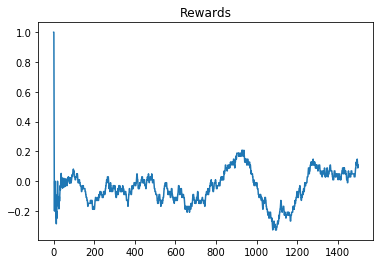

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(avg)
plt.title("Rewards")
plt.show()

# plot_running_avg(totalrewards)

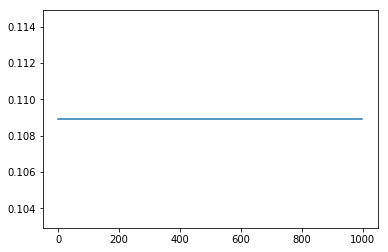

In [0]:
avg = [ totalrewards[max(0, n-100):(n+1)].mean() for i in range(1000) ]

plt.plot(avg)

In [0]:
import numpy as np
a = np.array( [ [1,2,0,2], [2,2,1,1] ] )
b = a.copy()

print(b)


print( rev(a) )

[[1 2 0 2]
 [2 2 1 1]]
[[2 1 0 1]
 [1 1 2 2]]


# print( env.board)

In [0]:
for j in range( env.C-3):
    print(a[j:j+4])

[[1 2 0 2]
 [2 2 1 1]]
[[2 2 1 1]]
[]
[]


In [0]:
for j in range( env.C-3):
    print(a[j:j+4] == [a[j]]*4)

In [0]:
env = Environment()

In [0]:
env.reset()
env.board

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [0]:
env.R

6

In [0]:
env.reset()

In [0]:
env.board

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [0]:
import copy
root = tkinter.Toplevel()#to Tk(  )

img = ImageTk.PhotoImage(Image.open("/Users/yeezhianliew/Downloads/Connect4-master 2/keno.png"))

keno = ImageTk.PhotoImage(Image.open("/Users/yeezhianliew/Downloads/Connect4-master 2/keno.png"))
red = ImageTk.PhotoImage(Image.open("/Users/yeezhianliew/Downloads/Connect4-master 2/kokkino.png"))
blue = ImageTk.PhotoImage(Image.open("/Users/yeezhianliew/Downloads/Connect4-master 2/ble.png"))

env.reset()

observation = env.board.copy().flatten()
prev_observation = observation.copy()

def update_board():
    
    r = 0
    c = 0

    tkinter.Button(root, text='R%s/C%s'%(r,c),
        borderwidth=1, command = lambda: helloCallBack( 0 ) ).grid(row=0,column=0)
    tkinter.Button(root, text='R%s/C%s'%(r,c),
        borderwidth=1, command = lambda: helloCallBack( 1 ) ).grid(row=0,column=1)
    tkinter.Button(root, text='R%s/C%s'%(r,c),
        borderwidth=1, command = lambda: helloCallBack( 2 ) ).grid(row=0,column=2)
    tkinter.Button(root, text='R%s/C%s'%(r,c),
        borderwidth=1, command = lambda: helloCallBack( 3 ) ).grid(row=0,column=3)
    tkinter.Button(root, text='R%s/C%s'%(r,c),
        borderwidth=1, command = lambda: helloCallBack( 4 ) ).grid(row=0,column=4)
    tkinter.Button(root, text='R%s/C%s'%(r,c),
        borderwidth=1, command = lambda: helloCallBack( 5 ) ).grid(row=0,column=5)
    tkinter.Button(root, text='R%s/C%s'%(r,c),
        borderwidth=1, command = lambda: helloCallBack( 6 ) ).grid(row=0,column=6)
    
    #update the board
    for r in range(6):
        for c in range(7):
            if env.board[r][c] == 0:
                cur = keno
            elif env.board[r][c] == 1:
                cur = red
            else:
                cur = blue
                
            tkinter.Label(root, text='R%s/C%s'%(r,c),
                borderwidth=1, image=cur ).grid(row=r+1,column=c)

def helloCallBack(value):
    done = False
    
    global observation, prev_observation
    
    if env.isFinal() > 0:
        return
    
    prev_observation = observation.copy().flatten()
    
    #do action
    placed = env.step(who=1, action=value)
    if placed == False:
        return        

    #move has been done, environment has moved to next state, so update
    prev_observation = observation.copy().flatten()
    observation = env.board.copy().flatten()

    if env.isFinal() > 0:
        done = True
        print( "CONGRATULATIONS! YOU WON! :)")
        update_board()
        return

    while True:
        #until a valid action is given
        #action = int( input('Player 2 input') )

        #agent 2 has to take an action based on the "reversed state"
        #reversed state: every 1 becomes 2 and vice versa
        action = model.sample_action( rev(observation), eps)

        placed = env.step(who=2, action=action)
        if placed == True:
            break

    #move has been done, environment has moved to next state, so update
    prev_observation = observation.copy().flatten()
    observation = env.board.copy().flatten()
    
    #end of do actions

    if env.isFinal() > 0:
        done = True
        print("Sorry :(, You lost!")
        update_board()
        return
        
    #end of logic
    
    #update the board
    update_board()    
    print(value)
    #tkMessageBox.showinfo( "Hello Python", "Hello World")
    
#B = Tkinter.Button(top, text ="Hello", command = helloCallBack)

update_board()

#root
root.mainloop(  )

3
4
2
CONGRATULATIONS! YOU WON! :)


In [0]:
env.reset()

### Save Session

In [0]:
saver = tf.train.Saver()

import os
save_path = saver.save(session, os.getcwd() + "/" + "connect_4_model.ckpt")
print("Model saved in path: %s" % save_path)


#saver.restore(session, "")

In [0]:
saver.restore(session, os.getcwd() + "/" + "connect_4_model.ckpt" )

INFO:tensorflow:Restoring parameters from /home/sotirisnik/connect4/connect_4_model.ckpt
